## Create data with artificial scores

In [25]:
import json
import random
import os

NUM_INTENTS = 10
NLU_NAMES = ['watson', 'luis', 'snips', 'rasa-sklearn', 'rasa-diet']

def get_nlu_result_dir(nlu, version):
    return '../results/' + nlu + '/v' + str(version)

def get_nlu_result_file(nlu, version, split_num):
    nlu_result_file = get_nlu_result_dir(nlu, version) + '/' + nlu + '_split_' + str(split_num) + '_results_v' + str(version) + '.json'
    return nlu_result_file

def normalize(vector):
    normalized_vector = [v/sum(vector) for v in vector]
    return normalized_vector

def ensure_dir_exists(path):
    if not os.path.exists(path):
        os.mkdir(path)

def create_results_with_artificial_scores(rescoring_function, dir_suffix):
    output_version = f'{VERSION}_{dir_suffix}'

    def create_results_for_nlu_and_split(nlu, split_num):
        data = json.load(open(get_nlu_result_file(nlu, VERSION, split_num)))
        for i in range(len(data)):
            test = data[i]
            if test['text'] != '':
                rescoring_function(test)
        json.dump(
            data, open(get_nlu_result_file(nlu, output_version, split_num), 'w'),
            indent=2)

    for nlu in NLU_NAMES:
        print(nlu)
        ensure_dir_exists(get_nlu_result_dir(nlu, output_version))
        for split_num in range(1, NUM_SPLITS+1):
            create_results_for_nlu_and_split(nlu, split_num)

def set_random_descending_scores(test):
    scores = sorted([random.uniform(0,1) for _ in range(NUM_INTENTS)], key=lambda x: -x)
    if nlu != 'watson':
        scores = normalize(scores)
    for i in range(NUM_INTENTS):
        test['intent_ranking'][i]['confidence'] = scores[i]

def set_uniform_descending_scores(test, width=0):
    for i in range(NUM_INTENTS):
        noise = random.uniform(-width, width)
        test['intent_ranking'][i]['confidence'] = 1 - (i + 1) / (NUM_INTENTS + 1) + noise

def reshuffle_non_top_rankings(test):
    non_top_indexes = list(range(1, NUM_INTENTS))
    random.shuffle(non_top_indexes)
    reshuffled_indexes = [0] + non_top_indexes
    reshuffled_intent_rankings = [
        test['intent_ranking'][i]
        for i in reshuffled_indexes
    ]
    test['intent_ranking'] = reshuffled_intent_rankings
    return test

def set_perfectly_calibrated_scores_given_accuracy(test):
    if test['intent_ranking'][0]['name'] == test['correct_intent']:
        test['intent_ranking'][0]['confidence'] = 0.9
        for i in range(1, NUM_INTENTS):
            test['intent_ranking'][i]['confidence'] = (1 - 0.9) / (NUM_INTENTS - 1)
    else:
        for i in range(0, NUM_INTENTS):
            if test['intent_ranking'][i]['name'] == test['correct_intent']:
                score = 0.3
            else:
                score = (1 - 0.3) / (NUM_INTENTS - 1)
            test['intent_ranking'][i]['confidence'] = score
        test['intent_ranking'] = sorted(test['intent_ranking'], key=lambda ranking: -ranking['confidence'])

def set_perfectly_calibrated_scores_given_rankings(test, noise=0):
    if test['intent_ranking'][0]['name'] == test['correct_intent']:
        test['intent_ranking'][0]['confidence'] = 0.9 + random.uniform(-noise, noise)
        for i in range(1, NUM_INTENTS):
            test['intent_ranking'][i]['confidence'] = 0.25 * (1 - (i + 1) / (NUM_INTENTS + 1)) + random.uniform(-noise, noise)
    else:
        test['intent_ranking'][0]['confidence'] = 0.8 + random.uniform(-noise, noise)
        for i in range(1, NUM_INTENTS):
            test['intent_ranking'][i]['confidence'] = 0.25 + 0.25 * (1 - (i + 1) / (NUM_INTENTS + 1)) + random.uniform(-noise, noise)

def set_flat_scores(test):
    test['intent_ranking'][0]['confidence'] = 0.5
    for i in range(1, NUM_INTENTS):
        test['intent_ranking'][i]['confidence'] = (1 - 0.5) / (NUM_INTENTS + 1)
    
            
#def set_minimally_calibrated_scores_given_accuracy(test):
#    test['intent_ranking'][0]['confidence'] = 0.5
#    for i in range(1, NUM_INTENTS):
#        test['intent_ranking'][i]['confidence'] = (1 - 0.5) / (NUM_INTENTS - 1)

#create_results_with_artificial_scores(set_random_descending_scores, "random")
#create_results_with_artificial_scores(set_uniform_descending_scores, "uniform")
#create_results_with_artificial_scores(lambda test: set_uniform_descending_scores(test, 0.049), "uniform_w_noise")
#create_results_with_artificial_scores(
#    lambda test: set_uniform_descending_scores(reshuffle_non_top_rankings(test), 0.049),
#    "reshuffled_uniform_w_noise")
#create_results_with_artificial_scores(set_perfectly_calibrated_scores_given_accuracy, "perfectly_calibrated")
#create_results_with_artificial_scores(set_perfectly_calibrated_scores_given_rankings, "perfectly_calibrated")
#create_results_with_artificial_scores(
#    lambda test: set_perfectly_calibrated_scores_given_rankings(test, 0.045),
#    "perfectly_calibrated_w_noise")
create_results_with_artificial_scores(set_flat_scores, "flat")






watson
luis
snips
rasa-sklearn
rasa-diet


## Rank-level score range sizes

watson


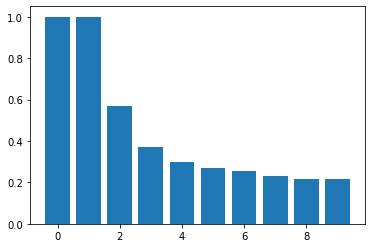

luis


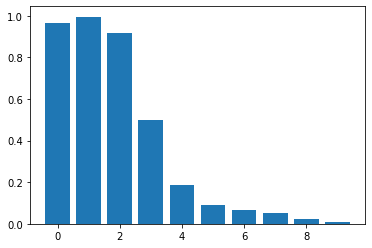

snips


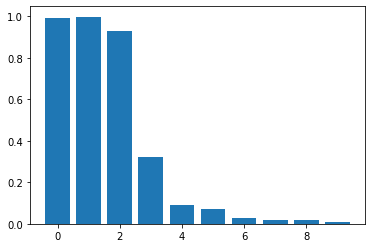

rasa-sklearn


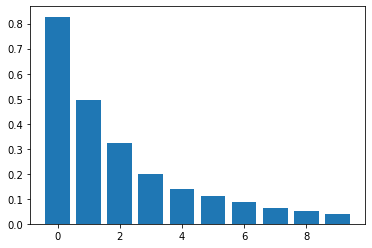

rasa-diet


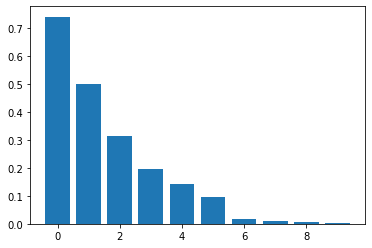

In [73]:
def get_scores(nlu, rank):
    for iteration in range(NUM_SPLITS):
        split_num = iteration + 1
        nlu_result_file = get_nlu_result_file(nlu, VERSION, split_num)
        data = remove_empty_preds(load_json(nlu_result_file))
        for test in data:
            yield test['intent_ranking'][rank]['confidence']

for i, nlu in enumerate(NLU_NAMES):
    print(nlu)
    sizes = []
    for rank in range(NUM_INTENTS):
        #print('rank', rank)
        scores = list(get_scores(nlu, rank))
        size = max(scores) - min(scores)
        #print(nlu, sd)
        sizes.append(size)
        
    fig, ax = plt.subplots()
    ax.bar(range(NUM_INTENTS), sizes)
    plt.show()


## Rank-level score SD

watson


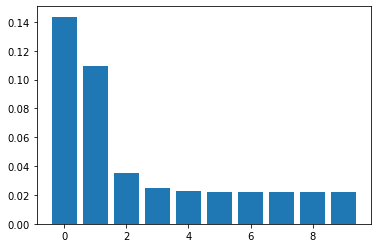

luis


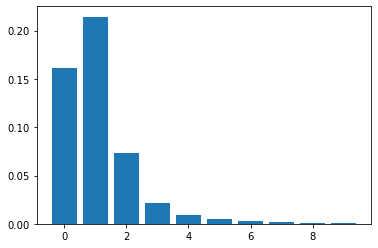

snips


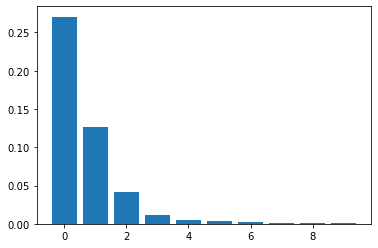

rasa-sklearn


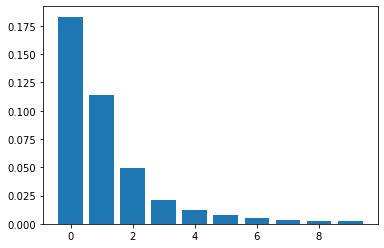

rasa-diet


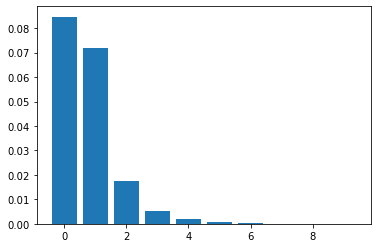

In [3]:
for i, nlu in enumerate(NLU_NAMES):
    print(nlu)
    sds = []
    for rank in range(NUM_INTENTS):
        #print('rank', rank)
        scores = list(get_scores(nlu, rank))
        sd = stdev(scores)
        #print(nlu, sd)
        sds.append(sd)
        
    fig, ax = plt.subplots()
    ax.bar(range(NUM_INTENTS), sds)
    plt.show()




